# Evaluation of the transcripts: Metrics & time passed to verify

- The first part of this notebook is designed to assess the performance of predictions after manual verification. *(Also providing enhanced visual HTML files to help interpret metrics clearly.)*

    - After manually verifying transcripts, you can use the verified transcripts as reference (ground truth) data to test the accuracy of various models.
    
    - **However**, it's essential to note that if the reference file (ground truth) was created by using a model’s predictions as a template the ground truth may carry a bias towards that initial model. *For instance, if a model omitted interruptions or adjusted sentence structure and the verifier found these changes accurate in context, these modifications might remain, unintentionally favoring that model.*

- The second part of the notebook focuses on tracking the time spent verifying each transcript. This data allows you to quantify time savings, providing insights into the efficiency of each model based on verification time.

In [1]:
import pandas as pd
import numpy as np
import shutil
import os

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set()

from utils.evaluation_helpers import process_folder, load_data_time, compute_der
from utils.format_helpers import get_files

## Predictions vs References: Performance evaluation (ASR & Diarization)

### Preparing evaluation folder (Predictions vs References)

Usefull if want to test/compare differents models.

In [ ]:
directories = ['../results/Compassion', '../results/OBE1', '../results/OBE2'] # The csv file that you want to compare
pred_folder = '../evaluation/predictions' # Specify the name if trying to compare different ASR/Diarization models.

def copy_csv_files(directories, pred_folder):
    pred_files = []
    for directory in directories:
        pred_files.append(get_files(directory, 'csv'))
    pred_files = [item for sublist in pred_files for item in sublist]

    os.makedirs(pred_folder, exist_ok=True)
    for file in pred_files:
        shutil.copy(file, pred_folder)

copy_csv_files(directories, pred_folder)

### ASR and Diarization metrics + Visual Tool to be better compare & understand

In [ ]:
# Hands-on parameters to better estimate the performance of the ASR system, as the diariasation task may skip whole sentences worse unfairly the WER metric
max_insert_length = None # Exclude insertions longer than # words from the WER calculation
                         # None: There is no limit on the length of insertions

prediction_folder = "../evaluation/predictions"
reference_folder = "../evaluation/references"

# Provide the orignal length of the audio file, 
# Without this it only have the interval of speech detected by the model, therefore worsen the DER metric.
orignal_info = pd.read_csv("./outputs/audio_data.csv")

metric = process_folder(prediction_folder, reference_folder, max_insert_length, info=orignal_info)
metric.to_csv('../performance_evaluation/metrics.csv', index=False)

Processing file: ID 05.csv
Combined HTML file saved as ../evaluation/predictions\visual_comparison\ID 05_Diarization.html
Processed file: ID 05.csv
Processing file: Id 08.csv
Combined HTML file saved as ../evaluation/predictions\visual_comparison\Id 08_Diarization.html
Processed file: Id 08.csv
Processing file: Id 13.csv
Combined HTML file saved as ../evaluation/predictions\visual_comparison\Id 13_Diarization.html
Processed file: Id 13.csv
Processing file: Id 13b.csv
Combined HTML file saved as ../evaluation/predictions\visual_comparison\Id 13b_Diarization.html
Processed file: Id 13b.csv
Processing file: Id 14.csv
Combined HTML file saved as ../evaluation/predictions\visual_comparison\Id 14_Diarization.html
Processed file: Id 14.csv
Processing file: Id 15.csv
Combined HTML file saved as ../evaluation/predictions\visual_comparison\Id 15_Diarization.html
Processed file: Id 15.csv
Processing file: Id 16.csv
Combined HTML file saved as ../evaluation/predictions\visual_comparison\Id 16_Diar

### (Optional) Dialogue DER Analysis in CSV instead than in HTML

In [ ]:
def dialogue_DER(reference_file, prediction_file, output_file):
    df_ref, df_pred = load_data_time(reference_file, prediction_file)
    dialogue_df, error_durations = compute_der(df_ref, df_pred)

    # Display error durations and DER
    print("\nError Durations and DER:")
    for key, value in error_durations.items():
        if key == 'DER':
            print(f"{key}: {value:.2%}")
        else:
            print(f"{key}: {value:.3f} seconds")

    # Optionally, save the DataFrame to a CSV file
    dialogue_df.to_csv(output_file, index=False)

In [ ]:
reference_file = "../evaluation/references/S301final.csv"
prediction_file = "../evaluation/predictions/S301final.csv"
output_file = 'dia_S301final_new.csv'

dialogue_DER(reference_file, prediction_file, output_file)


Error Durations and DER:
DER: 6.79%
Reference Speech Duration: 342.280 seconds
Missed Duration: 0.000 seconds
False Alarm Duration: 0.000 seconds
Confusion Duration: 23.240 seconds


### Visualize global metrics

In [2]:
df = pd.read_csv('../evaluation/metrics_none.csv')

In [7]:
def plot_wer_vs_der_scatter(df):
    """
    Plots an interactive scatter plot of WER vs. DER using Plotly.
    
    Args:
        df (pd.DataFrame): DataFrame containing the metrics, must include 'WER', 'DER', and 'Filename' columns.
    """
    fig = px.scatter(
        df,
        x='WER',
        y='DER',
        color='Filename',
        hover_data=['Filename'],  # Show filenames on hover
        labels={
            'WER': 'Word Error Rate (WER)',
            'DER': 'Diarization Error Rate (DER)'
        },
        title='Interactive Scatter Plot of WER vs. DER'
    )
    fig.update_traces(marker=dict(size=10))
    fig.update_layout(
        xaxis_title='Word Error Rate (WER)',
        yaxis_title='Diarization Error Rate (DER)',
        showlegend=False
    )
    fig.show()


def plot_histograms(df):
    """
    Plots histograms for WER and DER distributions.
    
    Args:
        df (pd.DataFrame): DataFrame containing the metrics.
    """
    plt.figure(figsize=(12, 6))
    
    # Histogram for WER
    plt.subplot(1, 2, 1)
    ax1 = sns.histplot(df['WER'], bins=10, kde=True, color='skyblue')
    plt.xlabel('Word Error Rate (WER)')
    plt.title('Distribution of WER')

    # Calculate total number of valid WER entries
    total_wer = df['WER'].dropna().shape[0]

    # Annotate each bar with percentage
    for p in ax1.patches:
        height = p.get_height()
        if height > 0:
            percentage = (height / total_wer) * 100
            ax1.annotate(f'{percentage:.1f}%', 
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom', fontsize=10, color='black')
    
    # Histogram for DER
    plt.subplot(1, 2, 2)
    ax2 = sns.histplot(df['DER'], bins=10, kde=True, color='salmon')
    plt.xlabel('Diarization Error Rate (DER)')
    plt.title('Distribution of DER')

    # Calculate total number of valid DER entries
    total_der = df['DER'].dropna().shape[0]
    
    # Annotate each bar with percentage
    for p in ax2.patches:
        height = p.get_height()
        if height > 0:
            percentage = (height / total_der) * 100
            ax2.annotate(f'{percentage:.1f}%', 
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom', fontsize=10, color='black')
    
    plt.tight_layout()
    plt.show()

def plot_boxplots(df):
    """
    Plots box plots for WER and DER.
    
    Args:
        df (pd.DataFrame): DataFrame containing the metrics.
    """
    plt.figure(figsize=(8, 4))
    
    # Melt the DataFrame for easier plotting with Seaborn
    melted_df = df.melt(id_vars='Filename', value_vars=['WER', 'DER'], var_name='Metric', value_name='Value')
    
    sns.boxplot(x='Metric', y='Value',hue="Metric" ,data=melted_df, palette=['skyblue', 'salmon'])
    
    plt.title('Box Plots of WER and DER')
    plt.xlabel('Metric')
    plt.ylabel('Error Rate')
    
    plt.tight_layout()
    plt.show()

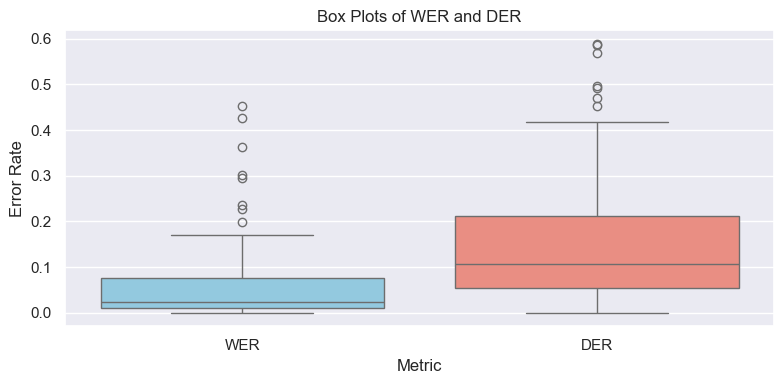

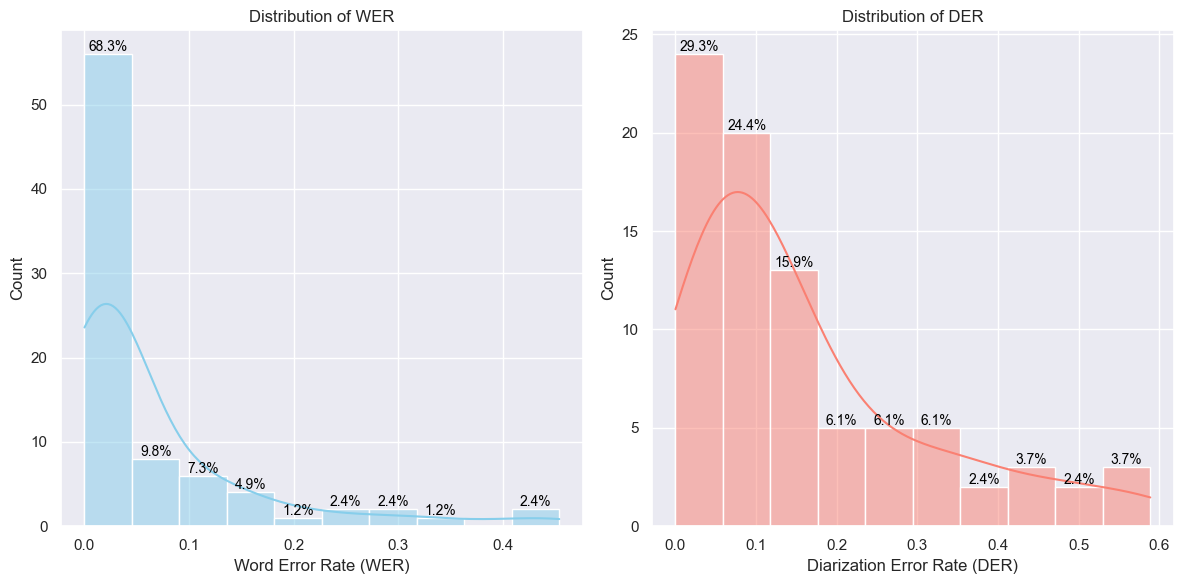

In [8]:
plot_boxplots(df)
plot_histograms(df)
plot_wer_vs_der_scatter(df)

## Estimation of time passed verify transcription

In [40]:
df = pd.read_csv("outputs/time_data.csv")

# Function to convert HH:MM:SS to total seconds
def time_to_seconds(time_str):
    try:
        h, m, s = map(int, time_str.split(':'))
        return h * 3600 + m * 60 + s
    except:
        return np.nan  # Return NaN if time_str is not a valid format

df['Verification_sec'] = df['Verification_time'].apply(time_to_seconds)

# Drop rows where 'Verification_sec' is NaN
df = df.dropna(subset=['Verification_sec'])

df.loc[:, 'Ratio'] = df['Verification_sec'] / df['Duration_sec'] 

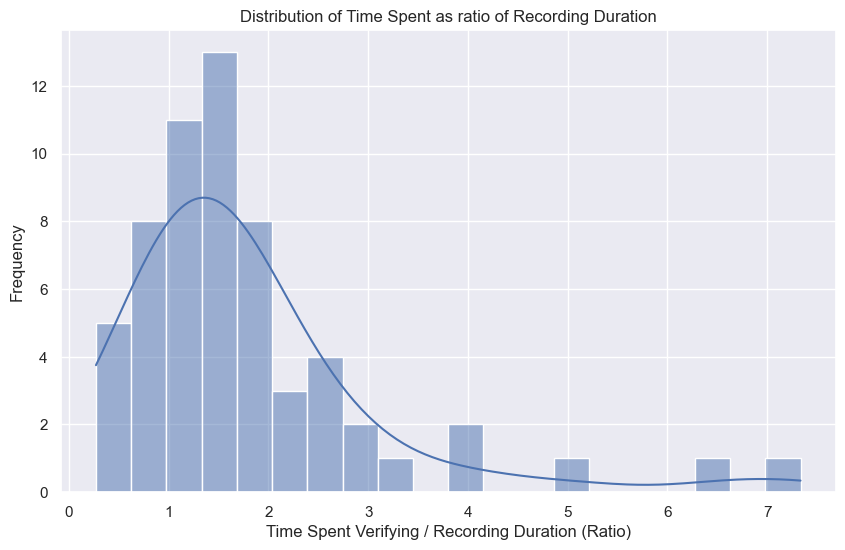

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Ratio'].dropna(), kde=True, bins=20)
plt.title('Distribution of Time Spent as ratio of Recording Duration')
plt.xlabel('Time Spent Verifying / Recording Duration (Ratio)')
plt.ylabel('Frequency')
plt.show()

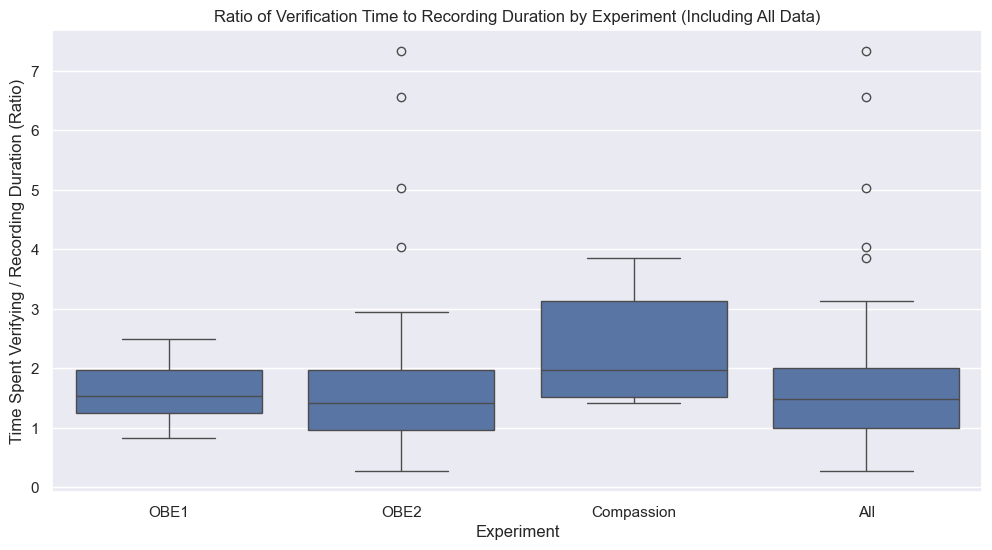

In [42]:
# Add a new row for the "All" category
df_all = df.copy()
df_all['Experiment'] = 'All'

# Concatenate the original data with the "All" data
df_combined = pd.concat([df, df_all])

# Plot the box plot with "All" as an additional category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_combined, x='Experiment', y='Ratio')
plt.title('Ratio of Verification Time to Recording Duration by Experiment (Including All Data)')
plt.xlabel('Experiment')
plt.ylabel('Time Spent Verifying / Recording Duration (Ratio)')
plt.show()